In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from config import path_to_repository
from analysis import BallBearingData # class for extracting all data from application and reapplication for ADC, IMU, and Camera Triggers
from analysis import DLC3DBendAngles # class for taking DLC 3d point data and converting to angles 
from analysis import bender_class # class for normalizing adc data, analyzing autobender tests
from analysis_adc_cam import ADC_CAM
from analysis_imu_cam import IMU_cam
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [146]:
# Upload Trials from particpant
# Upload only the parent *date* folder (e.g., "9_19_25").
# If something fails, verify your folder structure matches the "9_19_25" example.

root_dir="CSV Data/11_4_25"
folder_suffix_first  = "imu1_slow"       # e.g.  9_19_25_B1_slow
folder_suffix_second = "imu2_slow"       # e.g.  9_19_25_B2_slow

#10_28_25 (Tom)
#10_29_25 (bending data might be okay...check...resistance changing)
#11_2_25 (good)
#11_4_25 (good)
#11_7_25 (missing 90 degree cam calibration)
#11_16_25 (issues with AFAP P4)

##################### raw adc or imu data for any test ###############################



cam = IMU_cam(
    root_dir=root_dir,
    path_to_repo=path_to_repository,
    folder_suffix_first=folder_suffix_first,
    folder_suffix_second=folder_suffix_second,
)

# Original style
first_trials  = cam.load_first()
second_trials = cam.load_second()

imu_first_dfs  = cam.extract_imu_dfs_first()   # or cam.extract_imu_dfs_by_trial(first_trials)
imu_second_dfs = cam.extract_imu_dfs_second()

print("n first IMU dfs:", len(imu_first_dfs))
print("n second IMU dfs:", len(imu_second_dfs))


n first IMU dfs: 2
n second IMU dfs: 2


## Obtain raw IMU traces for tasks

In [149]:
imu_trials_first  = cam.extract_imu_dfs_by_trial(first_trials)
imu_trials_second = cam.extract_imu_dfs_by_trial(second_trials)
print("Number of first IMUrials:", len(imu_trials_first))
print("Number of second IMU trials:", len(imu_trials_second))



Number of first IMUrials: 2
Number of second IMU trials: 2


# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*') and DLC 3D point data (two separate dataframes)

This is where you should probably also load the DLC data and combine with cam_trials_first and cam_trials_second.    See my BallBearingClass for examples of how to do that.  

## NOTE (12/2/2025):  NO LONGER USING .mat data for timestamps, hence commented out this block

In [151]:


#cam_trials_first = cam.extract_mat_dfs_by_trial(
#    first_trials,
#    mat_name="flir_data.mat",
#    prefix="ts",
#    add_labels=True,
#    trial_base=1,
#    set_label="first_cam",
#    include_path=True,
#)

#cam_trials_second = cam.extract_mat_dfs_by_trial(
#    second_trials,
#    mat_name="flir_data.mat",
#    prefix="ts",
#    add_labels=True,
#    trial_base=1,
#    set_label="first_cam",
#    include_path=True,
#)

# Or new convenience methods
#cam_trials_first  = cam.extract_mat_dfs_first()
#cam_trials_second = cam.extract_mat_dfs_second()

#print("FLIR first:",  len(cam_trials_first))
#print("FLIR second:", len(cam_trials_second))


# Get per-trial camera timestamp tables from data_trigger_time csv fles (prefix 'ts*') 

This is where you should probably also load the DLC data and combine with cam_trials_first and cam_trials_second.    See my BallBearingClass for examples of how to do that.  

In [154]:
cam_trials_first = cam.extract_trigger_time_dfs_by_trial(
    first_trials,
    add_labels=True,
    trial_base=1,
    set_label="first_cam",
    include_path=True,
)

cam_trials_second = cam.extract_trigger_time_dfs_by_trial(
    second_trials,
    add_labels=True,
    trial_base=1,
    set_label="second_cam",
    include_path=True,
)

print("Trig first:",  len(cam_trials_first))
print("Trig second:", len(cam_trials_second))


Trig first: 2
Trig second: 2


## Get DLC raw csv data

In [156]:
dlc3d_trials_first = cam.extract_dlc3d_dfs_by_trial(
    first_trials,
    add_labels=True,
    trial_base=1,
    set_label="first_cam",
    include_path=True,
)

dlc3d_trials_second = cam.extract_dlc3d_dfs_by_trial(
    second_trials,
    add_labels=True,
    trial_base=1,
    set_label="second_cam",
    include_path=True,
)

# ---------- 3) Coerce DLC columns to MultiIndex using ADC_CAM helper ----------
dlc3d_trials_first  = [cam._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
dlc3d_trials_second = [cam._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]

print("DLC first:",  len(dlc3d_trials_first))
print("DLC second:", len(dlc3d_trials_second))


DLC first: 2
DLC second: 2


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

In [158]:
# ---------- 4) Compute MCP + wrist angles (per trial) using IMU_cam helpers ----------

# 2) Compute angles via IMU_cam helpers
aug_first, tall_first = cam.compute_dlc3d_angles_first(
    dlc3d_trials_first,
    signed_in_plane=True,
)

aug_second, tall_second = cam.compute_dlc3d_angles_second(
    dlc3d_trials_second,
    signed_in_plane=True,
)

print("len(aug_first)  vs cam_trials_first:",
      len(aug_first),  "vs", len(cam_trials_first))
print("len(aug_second) vs cam_trials_second:",
      len(aug_second), "vs", len(cam_trials_second))



len(aug_first)  vs cam_trials_first: 2 vs 2
len(aug_second) vs cam_trials_second: 2 vs 2


## Combine DLC3D bend angles and RPi timestamp data

In [160]:
dlc3D_angles_first  = cam.attach_cam_timestamps_first(
    aug_first,
    cam_trials=cam_trials_first,
    time_col_name="timestamp",
    new_col_name="cam_timestamp",
)

dlc3D_angles_second = cam.attach_cam_timestamps_second(
    aug_second,
    cam_trials=cam_trials_second,
    time_col_name="timestamp",
    new_col_name="cam_timestamp",
)

print("len(dlc3D_angles_first):",  len(dlc3D_angles_first))
print("len(dlc3D_angles_second):", len(dlc3D_angles_second))




len(dlc3D_angles_first): 2
len(dlc3D_angles_second): 2


## Filter rows with low likelihood DLC estimation

In [163]:
# Filter out low-likelihood frames before doing ADC alignment / comparisons
dlc3D_angles_first_filt = cam.filter_angle_trials_by_likelihood(
    dlc3D_angles_first,
    bodyparts=("MCP", "PIP", "hand"),
    min_likelihood=0.45,
)

dlc3D_angles_second_filt = cam.filter_angle_trials_by_likelihood(
    dlc3D_angles_second,
    bodyparts=("MCP", "PIP", "hand"),
    min_likelihood=0.45,
)


print(len(dlc3D_angles_first[0]),  len(dlc3D_angles_first_filt[0]))
print(len(dlc3D_angles_second[0]), len(dlc3D_angles_second_filt[0]))



198 183
197 196


## Compute bend angle from two IMU's

In [165]:
#aug_plane_first, tall_plane_first = cam.compute_imu_plane_bend_by_trial(
#    imu_trials_first,
#    set_label="first_cam",
#    quat_cols=("euler1","euler2"),
#    quat_order="wxyz",
#    fixed_axes=("z","y"),
#    moving_axes=("z","y"),
#    out_col="imu_joint_deg_plane",
#)

#aug_plane_second, tall_plane_first = cam.compute_imu_plane_bend_by_trial(
#    imu_trials_second,
#    set_label="second_cam",
#    quat_cols=("euler1","euler2"),
#    quat_order="wxyz",
#    fixed_axes=("x","y"),
#    moving_axes=("x","y"),
#    out_col="imu_joint_deg_plane",
#)



In [167]:
# ======================= IMU pure-quat flexion pipeline =======================

#TRIAL_LEN_SEC = 10.0
#QUAT_COLS     = ("euler2", "euler1")   # wrist, palm quats
#QUAT_ORDER    = "wxyz"                 # or "xyzw" to match BNO055
#OUT_COL       = "imu_joint_deg_rx_py"  # keep same name so rest of code works

# 1) Compute IMU *relative pitch* (wrist→palm) for first and second sets
#aug_imu_first, imu_tall_first = cam.compute_imu_relative_pitch_first(
#    trial_len_sec=TRIAL_LEN_SEC,
#    quat_cols=QUAT_COLS,
#    quat_order=QUAT_ORDER,
#    out_col=OUT_COL,
#    zero_baseline=True,   # <<< ensure each trial starts at 0°
#)

#aug_imu_second, imu_tall_second = cam.compute_imu_relative_pitch_second(
#    trial_len_sec=TRIAL_LEN_SEC,
#    quat_cols=QUAT_COLS,
#    quat_order=QUAT_ORDER,
#    out_col=OUT_COL,
#    zero_baseline=True,   # <<< same here
#)

#print("len(aug_imu_first)  vs imu_trials_first:",  len(aug_imu_first),  "vs", len(imu_trials_first))
#print("len(aug_imu_second) vs imu_trials_second:", len(aug_imu_second), "vs", len(imu_trials_second))





In [168]:
# ======================= IMU DLC-style joint-angle pipeline =======================

TRIAL_LEN_SEC = 10.0
QUAT_COLS     = ("euler1", "euler2")   # tuple columns with (w,x,y,z) or (x,y,z,w)
FIXED_AXIS    = "y"
MOVING_AXIS   = "y"
QUAT_ORDER    = "wxyz"                 # use "xyzw" if that matches BNO055 output
OUT_COL       = "imu_azimuth_deg"  # to match old pipeline

# 1) Compute IMU joint angles for first and second sets
aug_imu_first, imu_tall_first = cam.compute_imu_joint_angles_first(
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
    out_col=OUT_COL,
)

aug_imu_second, imu_tall_second = cam.compute_imu_joint_angles_second(
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
    out_col=OUT_COL,
)

TRIAL_LEN_SEC = 10.0

# Breaking up angle into azimuth and pitch angles.  Azimuth is what we want here because the hand was rotated 90 degrees in wrist bending trials

aug_imu_first, tall_first = cam.compute_imu_bend_pitch_azimuth_first(
    quat_cols=("euler1", "euler2"),
    fixed_axis="y",
    moving_axis="y",
    plane_normal_axis="z",       # choose wrist out-of-plane axis
    quat_order="wxyz",
    bend_col="imu_bend_deg",
    pitch_col="imu_pitch_deg",
    azim_col="imu_azimuth_deg",
    time_col="t_sec",
    trial_len_sec=TRIAL_LEN_SEC,
    zero_baseline_bend=True,
    zero_baseline_pitch=True,
    zero_baseline_azim=False,
)

aug_imu_second, tall_second = cam.compute_imu_bend_pitch_azimuth_second(
    quat_cols=("euler1", "euler2"),
    fixed_axis="y",
    moving_axis="y",
    plane_normal_axis="z",
    quat_order="wxyz",
    bend_col="imu_bend_deg",
    pitch_col="imu_pitch_deg",
    azim_col="imu_azimuth_deg",
    time_col="t_sec",
    trial_len_sec=TRIAL_LEN_SEC,
    zero_baseline_bend=True,
    zero_baseline_pitch=True,
    zero_baseline_azim=False,
)

# After compute_imu_bend_pitch_azimuth_first/second
BEND_COL = "imu_azimuth_deg"

aug_imu_first  = cam.filter_joint_angle_jumps_in_trials(
    aug_imu_first,
    angle_col=BEND_COL,
    max_delta_deg=5.0,    # or whatever you trust physically (this is where imu euler angles are switching from positive to negative.  Only a few datapoints doing this)
    verbose=True,
)

aug_imu_second = cam.filter_joint_angle_jumps_in_trials(
    aug_imu_second,
    angle_col=BEND_COL,
    max_delta_deg=5.0,
    verbose=True,
)



# Apply to first & second sets
#aug_imu_first  = cam.zero_baseline_trials(aug_imu_first,  OUT_COL)
#aug_imu_second = cam.zero_baseline_trials(aug_imu_second, OUT_COL)

# Use average of first n samples as baseline
aug_imu_first = IMU_cam.zero_baseline_trials_windowed(
    aug_imu_first,
    angle_col=BEND_COL,
    n_points=40,
    use_median=True,   # set True if you prefer median
    abs_values=True,
)

aug_imu_second = IMU_cam.zero_baseline_trials_windowed(
    aug_imu_second,
    angle_col=BEND_COL,
    n_points=40,
    use_median=True,
    abs_values=True,
)

print("len(aug_imu_first)  vs imu_trials_first:",  len(aug_imu_first),  "vs", len(imu_trials_first))
print("len(aug_imu_second) vs imu_trials_second:", len(aug_imu_second), "vs", len(imu_trials_second))






[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 174 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 29 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 11 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 2 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 2 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_an

## Align Timestamps by time threshold.  NOTE: NO SECONDARY ALIGNMENT!

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:4419: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:4420: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:4419: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8"

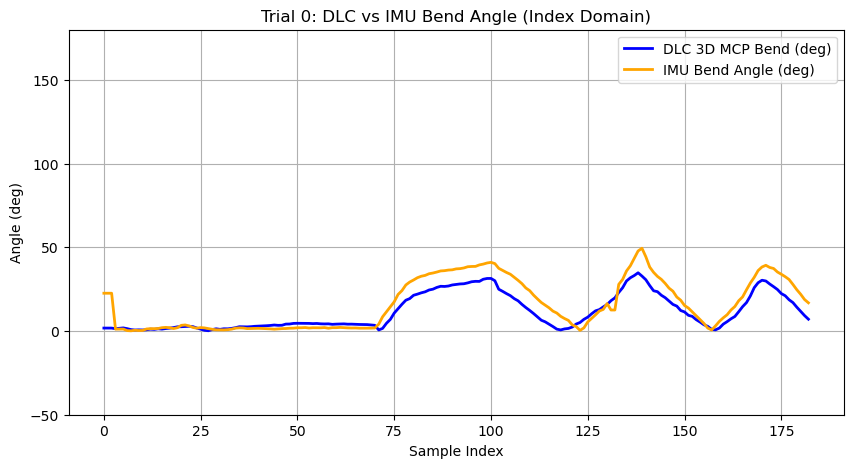

In [170]:
# Align FIRST set: DLC MCP angles vs ADC-calibrated angles
merged_first = cam.align_adc_theta_to_dlc_angles_for_set(
    dlc_angle_trials=dlc3D_angles_first_filt,
    adc_theta_trials=aug_imu_first,
    dlc_time_col="cam_timestamp",    # from attach_cam_timestamps_to_angles
    adc_time_col="timestamp",        # column in adc_first_theta
    adc_cols=["imu_azimuth_deg"],
    #adc_cols=["imu_joint_deg_rx_py"],      # or None to attach all ADC columns
    time_unit="ns",                   # <-- try 's' first; use 'ms' if your timestamps are in milliseconds
    tolerance="200ms",
    direction="nearest",
    suffix="_imu",
    keep_time_delta=True,
    drop_unmatched=True,
)

# Align SECOND set
merged_second = cam.align_adc_theta_to_dlc_angles_for_set(
    dlc_angle_trials=dlc3D_angles_second_filt,
    adc_theta_trials=aug_imu_second,
    dlc_time_col="cam_timestamp",
    adc_time_col="timestamp",
    adc_cols=["imu_azimuth_deg"],
    #adc_cols=["imu_joint_deg_rx_py"],      # or None to attach all ADC columns
    time_unit="ns",
    tolerance="200ms",
    direction="nearest",
    suffix="_imu",
    keep_time_delta=True,
    drop_unmatched=True,
)



def zero_baseline_merged(trials, angle_col):
    out = []
    for df in trials:
        if df is None or df.empty or angle_col not in df.columns:
            out.append(df)
            continue
        s = df[angle_col].dropna()
        if s.empty:
            out.append(df)
            continue
        baseline = s.iloc[0]
        df2 = df.copy()
        #df2[angle_col] = ((df2[angle_col] - baseline)).abs()
        df2[angle_col] = ((df2[angle_col] - baseline)).abs()
        #df2[angle_col] =  df2[angle_col] + 
        out.append(df2)
    return out


# Zero baseline AFTER alignment
#merged_first  = zero_baseline_merged(merged_first,  "imu_azimuth_deg_imu")
#merged_second = zero_baseline_merged(merged_second, "imu_azimuth_deg_imu")



# Hard cap: drop IMU samples above 90°
MAX_ANGLE_DEG = 90.0

merged_first = IMU_cam.drop_angle_above_threshold_in_trials(
    merged_first,
    angle_col="imu_azimuth_deg_imu",
    max_angle_deg=MAX_ANGLE_DEG,
    verbose=False,
)

merged_second = IMU_cam.drop_angle_above_threshold_in_trials(
    merged_second,
    angle_col="imu_azimuth_deg_imu",
    max_angle_deg=MAX_ANGLE_DEG,
    verbose=False,
)

#-------EXAMPLE PLOTTING------#

trial_idx = 0

# IMU column from alignment step
IMU_COL = "imu_azimuth_deg_imu"   # your OUT_COL

# DLC 3D angle column (MultiIndex: ('metric','mcp_bend_deg','deg'))
DLC_COL = ('metric', 'wrist_bend_deg', 'deg')

df = merged_first[trial_idx]

# Extract DLC angle column
dlc_angle = df[DLC_COL]
imu_angle = df[IMU_COL]

# Make plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dlc_angle.values, label="DLC 3D MCP Bend (deg)", color="blue", linewidth=2)
ax.plot(imu_angle.values, label="IMU Bend Angle (deg)", color="orange", linewidth=2)

ax.set_xlabel("Sample Index")
ax.set_ylabel("Angle (deg)")
ax.set_title(f"Trial {trial_idx}: DLC vs IMU Bend Angle (Index Domain)")
ax.grid(True)
ax.set_ylim(-50, 180)
ax.legend()

plt.show()




## EXAMPLE PLOTTING ALL TRIALS

   trial_index  best_lag_samples  rmse_deg  n_points  \
0            0                 0  6.000262       183   
1            1                 0  6.613670       195   

                          set_name  
0  FIRST (IMU baseline-subtracted)  
1  FIRST (IMU baseline-subtracted)  
   trial_index  best_lag_samples   rmse_deg  n_points  \
0            0                 0  13.470785       196   
1            1                 0  11.270101       197   

                           set_name  
0  SECOND (IMU baseline-subtracted)  
1  SECOND (IMU baseline-subtracted)  


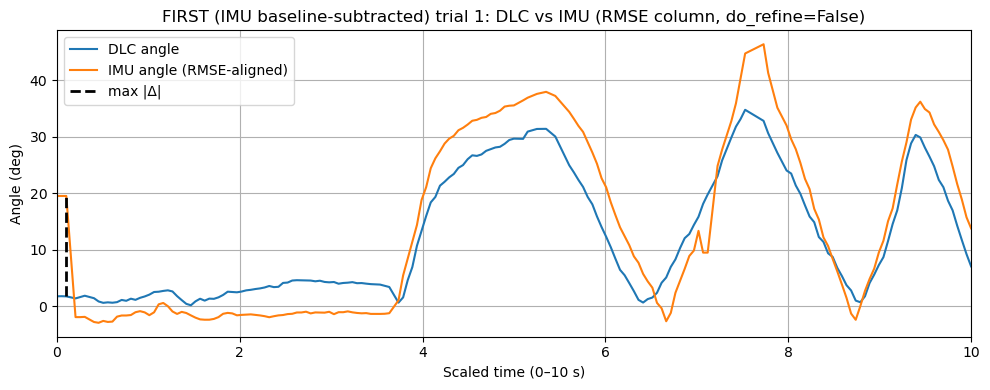

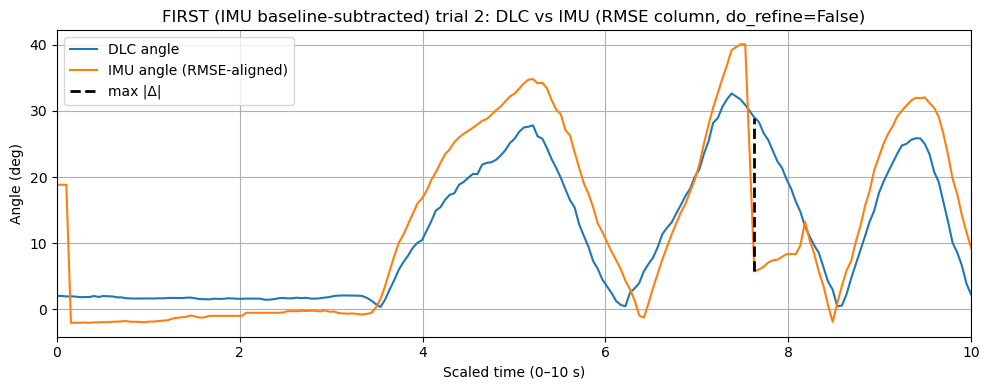

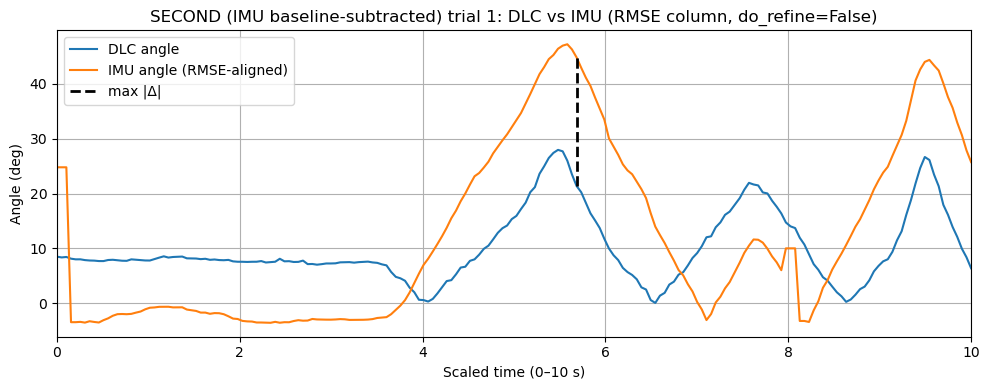

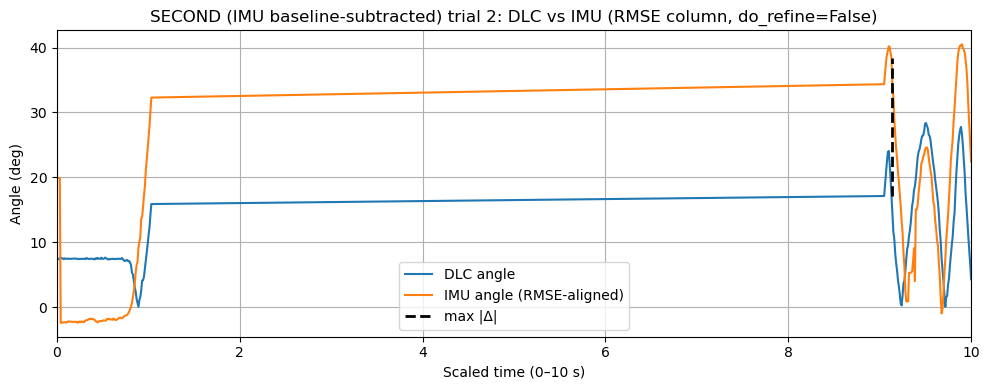

In [173]:
def add_baseline_subtracted_col(merged_trials, src_col, new_col, n0=30, method="mean"):
    """
    Adds a baseline-subtracted version of src_col to each merged trial DataFrame.
    Baseline is computed from the first n0 valid samples.
    """
    out = []
    for df in merged_trials:
        y = df[src_col].astype(float).to_numpy()

        # pick baseline window from first n0 finite values
        finite_idx = np.where(np.isfinite(y))[0]
        if finite_idx.size == 0:
            df[new_col] = np.nan
            out.append(df)
            continue

        # indices of first n0 finite samples
        idx0 = finite_idx[:min(n0, finite_idx.size)]
        baseline = np.nanmean(y[idx0]) if method == "mean" else np.nanmedian(y[idx0])

        df[new_col] = y - baseline
        out.append(df)

    return out


adc_col_raw = "imu_azimuth_deg_imu"
adc_col_zero = "imu_azimuth_deg_imu_zeroed"

merged_first  = add_baseline_subtracted_col(merged_first,  adc_col_raw, adc_col_zero, n0=40)
merged_second = add_baseline_subtracted_col(merged_second, adc_col_raw, adc_col_zero, n0=40)

# Now plot using the same function, just point adc_col to the zeroed column
refined_first, summary_first = cam.refine_alignment_by_rmse_for_set(
    merged_trials=merged_first,
    dlc_col=('metric', 'wrist_bend_deg', 'deg'),
    adc_col=adc_col_zero,
    max_lag_samples=5,
    time_col="cam_timestamp",
    plot_indices=[0, 1],
    set_name="FIRST (IMU baseline-subtracted)",
    do_refine=False,
)

refined_second, summary_second = cam.refine_alignment_by_rmse_for_set(
    merged_trials=merged_second,
    dlc_col=('metric', 'wrist_bend_deg', 'deg'),
    adc_col=adc_col_zero,
    max_lag_samples=5,
    time_col="cam_timestamp",
    plot_indices=[0, 1],
    set_name="SECOND (IMU baseline-subtracted)",
    do_refine=False,
)

print(summary_first)
print(summary_second)


   trial_index  best_lag_samples  rmse_deg  n_points set_name
0            0                 0  7.307522       183    FIRST
1            1                 0  7.252954       195    FIRST
   trial_index  best_lag_samples   rmse_deg  n_points set_name
0            0                 0  14.482978       196   SECOND
1            1                 0  11.621995       197   SECOND


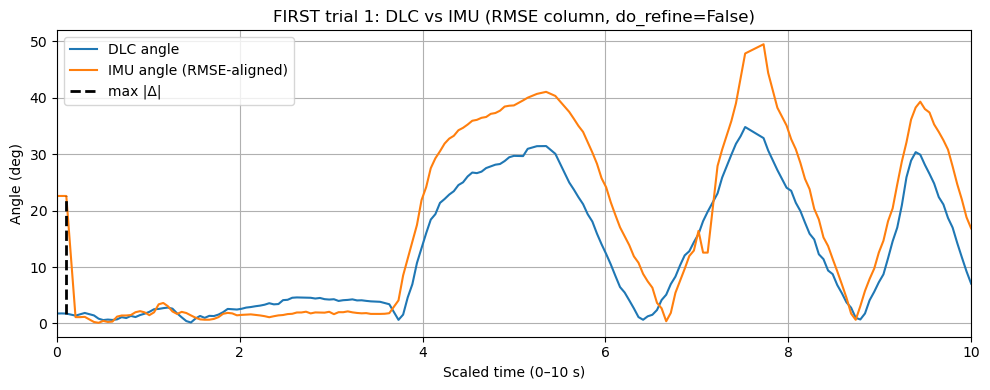

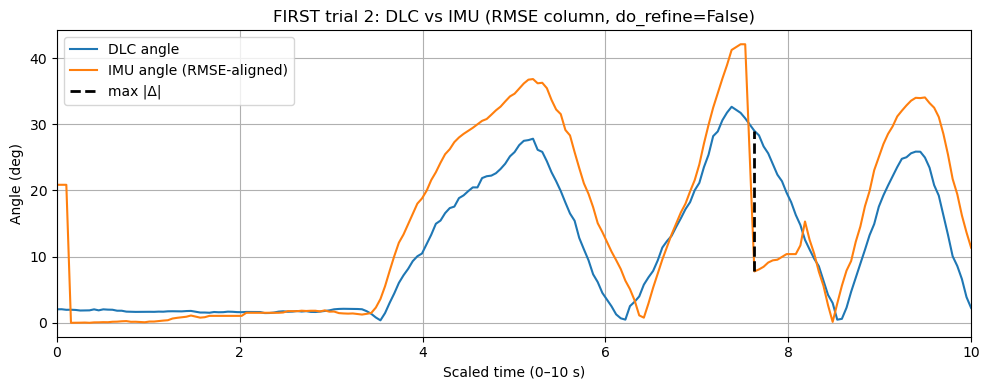

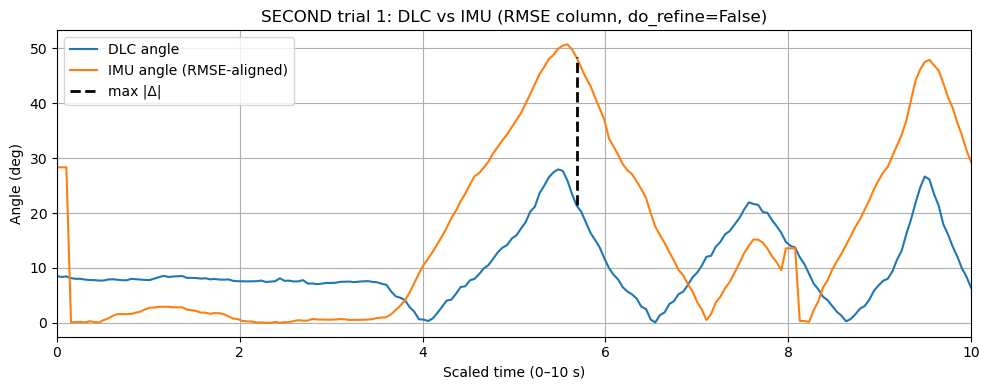

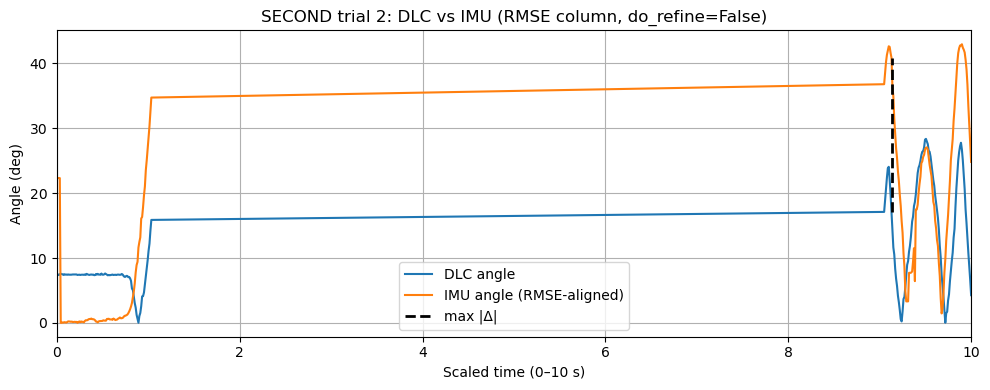

In [175]:
adc_col="imu_azimuth_deg_imu"

# Refine FIRST set and plot a few trials
refined_first, summary_first = cam.refine_alignment_by_rmse_for_set(
    merged_trials=merged_first,
    dlc_col=('metric', 'wrist_bend_deg', 'deg'),
    adc_col=adc_col,
    max_lag_samples=5, 
    time_col="cam_timestamp",   # or ("cam_timestamp", "", "")
    plot_indices=[0, 1],           # which trials to plot
    set_name="FIRST",
    do_refine = False,         # <-- NEW FLAG
)

print(summary_first)

# Refine SECOND set and plot a few trials
refined_second, summary_second = cam.refine_alignment_by_rmse_for_set(
    merged_trials=merged_second,
    dlc_col=('metric', 'wrist_bend_deg', 'deg'),
    adc_col=adc_col,
    max_lag_samples=5, 
    time_col="cam_timestamp",   # or ("cam_timestamp", "", "")
    plot_indices=[0, 1],           # which trials to plot
    set_name="SECOND",
    do_refine = False,         # <-- NEW FLAG
)

print(summary_second)


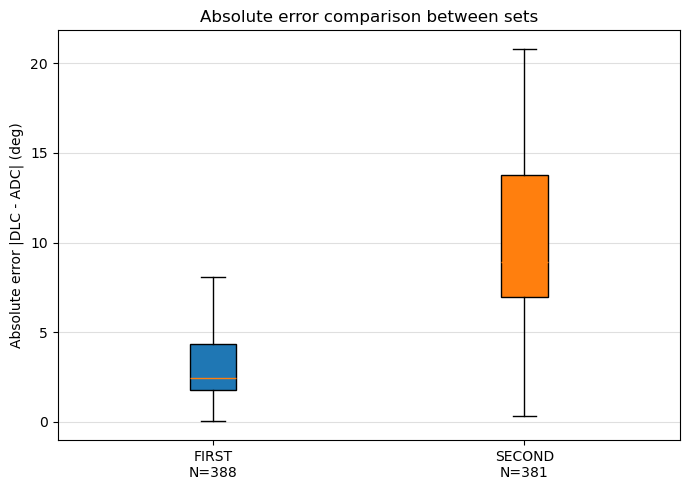

In [141]:
cam.plot_abs_error_box_two_sets(
    refined_first=refined_first,
    summary_first=summary_first,
    refined_second=refined_second,
    summary_second=summary_second,
    dlc_col=('metric', 'wrist_bend_deg', 'deg'),
    adc_rmse_col="imu_azimuth_deg_imu",
    trial_indices_first=[0, 1],    # FIRST set: trials 1 & 2 (0-based)
    trial_indices_second=[0, 1],   # SECOND set: trials 1 & 3
    label_first="FIRST",
    label_second="SECOND",
)

In [142]:
#11_16_25 imu1_slow looks great

#11_7_25 imu1_vfas looks great


# -----------------------------------------
# CONFIG: participants, speeds, and trial indices
# -----------------------------------------

participants = [
    {"name": "P1", "root_dir": "CSV Data/11_2_25"},
    {"name": "P2", "root_dir": "CSV Data/11_4_25"},
    {"name": "P3", "root_dir": "CSV Data/11_7_25"},
    {"name": "P4", "root_dir": "CSV Data/11_16_25"}
]

speed_tags   = ["slow", "medm", "fast", "vfas", "afap"]
speed_titles = ["Slow", "Medm", "Fast", "VFast", "AFAP"]

trial_indices_first_default  = [0, 1]
trial_indices_second_default = [0, 1]

min_dlc_likelihood = 0.4


# -----------------------------------------
# Run IMU-only pipeline for all (participant, speed)
# -----------------------------------------

results_imu = {}

for p in participants:
    for speed in speed_tags:
        key = (p["name"], speed)
        print(f"Processing IMU: {p['name']} - {speed}")

        results = cam.run_imu_cam_pipeline_for_participant_speed(
            root_dir=p["root_dir"],
            speed_tag=speed,
            path_to_repo=path_to_repository,
            imu_angle_col="imu_azimuth_deg",
            # keep default imu_time_col="timestamp" and time_unit="ns"
            time_unit="ns",
            imu_time_col="timestamp",
            imu_zero_window_n=40,
            imu_zero_window_use_median=True,
            imu_zero_window_abs=True,
            imu_jump_max_delta_deg=5.0,
            imu_max_angle_deg=90.0,
            min_dlc_likelihood=min_dlc_likelihood,
        )

        results_imu[key] = results





Processing IMU: P1 - slow
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 150 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 43 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 23 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 14 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 7 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 5 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 5 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 5 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 4 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 4 rows (|Δimu_azimuth_de

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P1 - medm
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 187 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 58 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 32 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 16 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 13 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 8 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 5 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 5 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 5 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 5 rows (|Δimu_azimuth_d

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P1 - fast
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 112 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 40 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 21 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 16 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 13 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 11 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 10 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 10 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 10 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 10 rows (|Δimu_azim

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P1 - vfas
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 446 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 151 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 71 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 50 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 46 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 38 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 29 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 29 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 29 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 26 rows (|Δimu_azi

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P1 - afap
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 435 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 162 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 52 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 45 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 39 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 38 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 35 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 35 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 32 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 31 rows (|Δimu_azi

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P2 - slow
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 174 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 29 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 11 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 2 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 2 rows (|Δimu_azimuth_deg

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P2 - medm
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 395 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 125 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 56 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 33 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 23 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 19 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 15 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 10 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 7 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 6 rows (|Δimu_azimu

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P2 - fast
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 87 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 29 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 14 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 10 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 9 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 8 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 6 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 6 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 6 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 6 rows (|Δimu_azimuth_deg

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P2 - vfas
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 225 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 86 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 38 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 28 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 23 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 15 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 15 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 13 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 12 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 12 rows (|Δimu_azim

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P2 - afap
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 418 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 157 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 76 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 62 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 49 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 41 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 35 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 33 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 31 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 29 rows (|Δimu_azi

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P3 - slow
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 247 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 48 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 15 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 9 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 8 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 4 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 4 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 2 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 2 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 2 rows (|Δimu_azimuth_deg

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P3 - medm
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 208 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 57 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 23 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 17 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 11 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 6 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 3 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 3 rows (|Δimu_azimuth_d

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P3 - fast
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 198 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 64 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 34 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 18 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 15 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 10 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 8 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 5 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 5 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 4 rows (|Δimu_azimuth_

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P3 - vfas
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 253 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 73 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 40 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 27 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 25 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 22 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 19 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 18 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 18 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 16 rows (|Δimu_azim

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P3 - afap
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 351 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 119 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 54 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 41 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 36 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 35 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 33 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 33 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 33 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 33 rows (|Δimu_azi

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P4 - slow
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 72 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 15 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 1 rows (|Δimu_azimuth_deg| 

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P4 - medm
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 86 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 13 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 1 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 1 rows (|Δimu_azimuth_deg| 

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P4 - fast
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 144 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 26 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 15 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 10 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 10 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 9 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 9 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 9 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 9 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 8 rows (|Δimu_azimuth_d

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P4 - vfas
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 275 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 105 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 42 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 33 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 29 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 27 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 25 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 25 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 25 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 25 rows (|Δimu_azi

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

Processing IMU: P4 - afap
[filter_joint_angle_jumps_in_trials] trial 0, iter 0: dropping 635 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 1: dropping 193 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 2: dropping 68 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 3: dropping 55 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 4: dropping 42 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 5: dropping 38 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 6: dropping 34 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 7: dropping 33 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 8: dropping 33 rows (|Δimu_azimuth_deg| > 5.0°)
[filter_joint_angle_jumps_in_trials] trial 0, iter 9: dropping 33 rows (|Δimu_azi

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1169: FutureWarning: Series.__getitem__ treating key

C:\Users\toppe\AppData\Local\Temp\ipykernel_4972\3038063023.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\toppe\AppData\Local\Temp\ipykernel_4972\3038063023.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\toppe\AppData\Local\Temp\ipykernel_4972\3038063023.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\toppe\AppData\Local\Temp\ipykernel_4972\3038063023.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  b

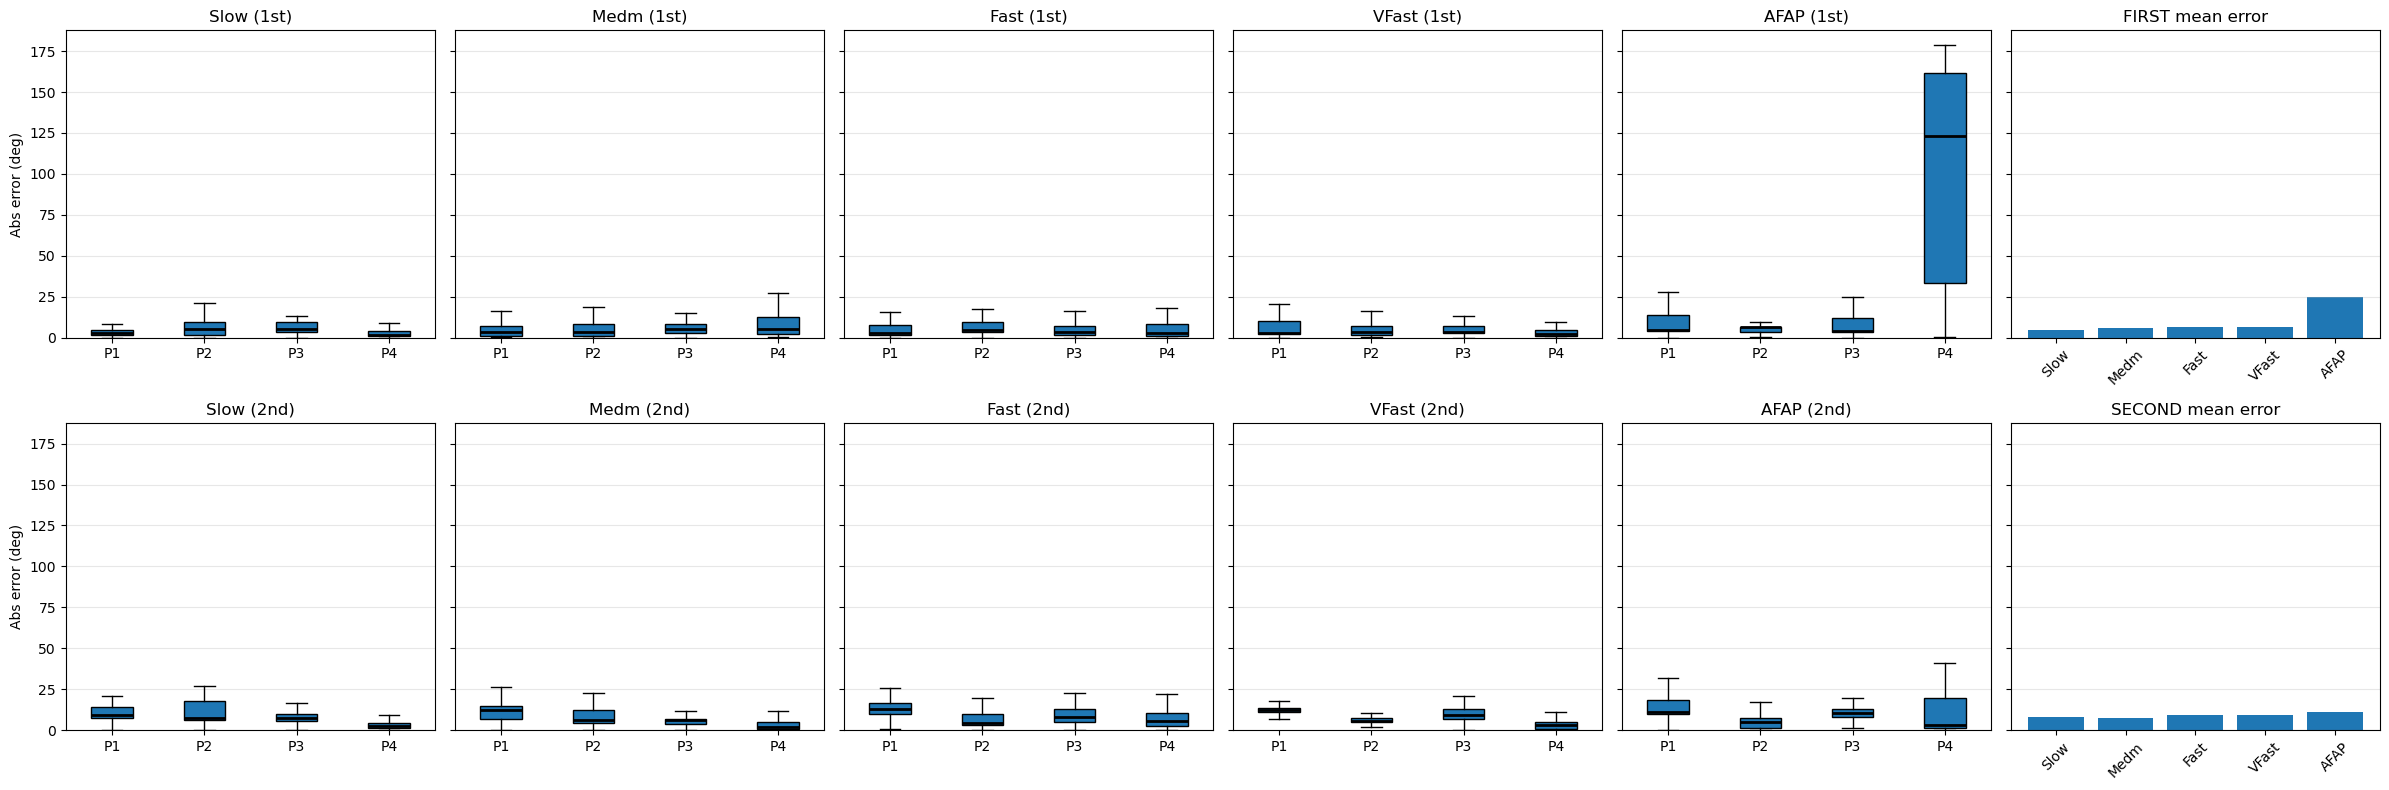

In [143]:
fig, axes = plt.subplots(2, 6, figsize=(24, 8), sharey=True)

def style_box(ax, data, labels, color="C1"):
    bp = ax.boxplot(
        data,
        labels=labels,
        showfliers=False,
        patch_artist=True,
    )
    for box in bp["boxes"]:
        box.set_facecolor(color)
    for med in bp["medians"]:
        med.set_color("k")
        med.set_linewidth(2.0)
    return bp


# ---- Row 1: FIRST (B1) ----
for col, (speed, title) in enumerate(zip(speed_tags, speed_titles)):
    ax = axes[0, col]
    D = []
    L = []

    for p in participants:
        key = (p["name"], speed)
        arr = results_imu.get(key, {}).get("abs_err_first", np.array([]))
        if arr.size == 0:
            continue
        D.append(arr)
        L.append(p["name"])

    if D:
        style_box(ax, D, L, color="C0")  # blue
    ax.set_title(f"{title} (1st)")
    if col == 0:
        ax.set_ylabel("Abs error (deg)")
    ax.grid(axis="y", alpha=0.3)


# ---- Row 2: SECOND (B2) ----
for col, (speed, title) in enumerate(zip(speed_tags, speed_titles)):
    ax = axes[1, col]
    D = []
    L = []

    for p in participants:
        key = (p["name"], speed)
        arr = results_imu.get(key, {}).get("abs_err_second", np.array([]))
        if arr.size == 0:
            continue
        D.append(arr)
        L.append(p["name"])

    if D:
        style_box(ax, D, L, color="C0")  # orange
    ax.set_title(f"{title} (2nd)")
    if col == 0:
        ax.set_ylabel("Abs error (deg)")
    ax.grid(axis="y", alpha=0.3)


# ---- Column 6: Summary mean errors ----
x = np.arange(len(speed_tags))

# FIRST
ax_sum1 = axes[0, 5]
mean_first = []
for speed in speed_tags:
    all_err = []
    for p in participants:
        arr = results_imu.get((p["name"], speed), {}).get("abs_err_first", np.array([]))
        if arr.size:
            all_err.append(arr)
    mean_first.append(np.nanmean(np.concatenate(all_err)) if all_err else np.nan)

ax_sum1.bar(x, mean_first, color="C0")
ax_sum1.set_xticks(x)
ax_sum1.set_xticklabels(speed_titles, rotation=45)
ax_sum1.set_title("FIRST mean error")
ax_sum1.grid(axis="y", alpha=0.3)


# SECOND
ax_sum2 = axes[1, 5]
mean_second = []
for speed in speed_tags:
    all_err = []
    for p in participants:
        arr = results_imu.get((p["name"], speed), {}).get("abs_err_second", np.array([]))
        if arr.size:
            all_err.append(arr)
    mean_second.append(np.nanmean(np.concatenate(all_err)) if all_err else np.nan)

ax_sum2.bar(x, mean_second, color="C0")
ax_sum2.set_xticks(x)
ax_sum2.set_xticklabels(speed_titles, rotation=45)
ax_sum2.set_title("SECOND mean error")
ax_sum2.grid(axis="y", alpha=0.3)


plt.tight_layout()
plt.show()


# FIGURE FOR PAPER (USES SEABORN PLOTTING)

In [145]:
fig, axes = IMU_cam.plot_imu_abs_error_summary_grid(
    results_imu,
    speed_titles=speed_title_map,
    speed_order=speed_tags,
    imu_angle_col="imu_azimuth_deg",
    example1_participant="P4",
    example1_speed="slow",
    example2_participant="P3",
    example2_speed="vfas",
    example_trial_idx=0,
    example_col_start=1,
    abs_err_ylim_examples=(0, 20),
    abs_err_ylim_summary=(0, 40),
    boxplot_wspace=0.1,
    example_col_gap_scale=6,
    bar_gap_from_afap=0.05,
    abs_err_ylim=(0, 40),
    exclude_participant_speed_for_summary=[("P4", "afap")],
)
plt.show()


NameError: name 'speed_title_map' is not defined